Copyright 2020 Google LLC. Double-click here for license information.
Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

In this exercise, you'll work with the Adult Census Income dataset, which is commonly used in machine learning literature. This data was extracted from the 1994 Census bureau database by Ronny Kohavi and Barry Becker.

Each example in the dataset contains the following demographic data for a set of individuals who took part in the 1994 Census:

Numeric Features
age: The age of the individual in years.
fnlwgt: The number of individuals the Census Organizations believes that set of observations represents.
education_num: An enumeration of the categorical representation of education. The higher the number, the higher the education that individual achieved. For example, an education_num of 11 represents Assoc_voc (associate degree at a vocational school), an education_num of 13 represents Bachelors, and an education_num of 9 represents HS-grad (high school graduate).
capital_gain: Capital gain made by the individual, represented in US Dollars.
capital_loss: Capital loss mabe by the individual, represented in US Dollars.
hours_per_week: Hours worked per week.
Categorical Features
workclass: The individual's type of employer. Examples include: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, and Never-worked.
education: The highest level of education achieved for that individual.
marital_status: Marital status of the individual. Examples include: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, and Married-AF-spouse.
occupation: The occupation of the individual. Example include: tech-support, Craft-repair, Other-service, Sales, Exec-managerial and more.
relationship: The relationship of each individual in a household. Examples include: Wife, Own-child, Husband, Not-in-family, Other-relative, and Unmarried.
gender: Gender of the individual available only in binary choices: Female or Male.
race: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Black, and Other.
native_country: Country of origin of the individual. Examples include: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, and more.
Prediction Task
The prediction task is to determine whether a person makes over $50,000 US Dollar a year.

Label
income_bracket: Whether the person makes more than $50,000 US Dollars annually.
Notes on Data Collection
All the examples extracted for this dataset meet the following conditions:

age is 16 years or older.
The adjusted gross income (used to calculate income_bracket) is greater than $100 USD annually.
fnlwgt is greater than 0.
hours_per_week is greater than 0.

In addition to importing the usual libraries, this setup code cell also installs Facets, an open-source tool created by PAIR that contains two robust visualizations we'll be using to aid in understanding and analyzing ML datasets.

In [4]:
# Import revelant modules and install Facets
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from matplotlib import rcParams
import seaborn as sns

# The following lines adjust the granularity of reporting. 
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

# For facets
from IPython.core.display import display, HTML
import base64
# !pip install facets-overview==1.0.0
from facets_overview.feature_statistics_generator import FeatureStatisticsGenerator

In [3]:
# import dataset
COLUMNS = ["age", "workclass", "fnlwgt", "education", "education_num",
           "marital_status", "occupation", "relationship", "race", "gender",
           "capital_gain", "capital_loss", "hours_per_week", "native_country",
           "income_bracket"]

train_csv = tf.keras.utils.get_file('adult.data', 
  'https://download.mlcc.google.com/mledu-datasets/adult_census_train.csv')
test_csv = tf.keras.utils.get_file('adult.data', 
  'https://download.mlcc.google.com/mledu-datasets/adult_census_test.csv')

train_df = pd.read_csv(train_csv, names=COLUMNS, sep=r'\s*,\s*', 
                       engine='python', na_values="?")
test_df = pd.read_csv(test_csv, names=COLUMNS, sep=r'\s*,\s*', skiprows=[0],
                      engine='python', na_values="?")

3989504/3974305 [==============================] - 0s 0us/step


# Analyzing the Adult Dataset with Facets

As mentioned in MLCC, it is important to understand your dataset before diving straight into the prediction task.

Some important questions to investigate when auditing a dataset for fairness:

### Are there missing feature values for a large number of observations?
### Are there features that are missing that might affect other features?
### Are there any unexpected feature values?
### What signs of data skew do you see?

In [5]:
# Visualize the Data in Facets
fsg = FeatureStatisticsGenerator()
dataframes = [
    {'table': train_df, 'name': 'trainData'}]
censusProto = fsg.ProtoFromDataFrames(dataframes)
protostr = base64.b64encode(censusProto.SerializeToString()).decode("utf-8")


HTML_TEMPLATE = """<script src="https://cdnjs.cloudflare.com/ajax/libs/webcomponentsjs/1.3.3/webcomponents-lite.js"></script>
        <link rel="import" href="https://raw.githubusercontent.com/PAIR-code/facets/1.0.0/facets-dist/facets-jupyter.html">
        <facets-overview id="elem"></facets-overview>
        <script>
          document.querySelector("#elem").protoInput = "{protostr}";
        </script>"""
html = HTML_TEMPLATE.format(protostr=protostr)
display(HTML(html))

We can see from reviewing the missing column that the following categorical features contain missing values:

workclass
occupation
Now, because it's only a small percentage of samples that contain either a missing workclass value or occupation value, we can safely drop those rows from the data set. If that percentage was much higher, then we would have to consider using a different data set that is more complete.

In [6]:
# A way to drop any row containing a missing value in the data set
# pandas.DataFrame.dropna(how="any", axis=0, inplace=True)

For hours_per_week, we can see that the minimum is 1, which might be a bit surprising, given that most jobs typically require multiple hours of work per week. For capital_gain and capital_loss, we can see that over 90% of values are 0. Given that capital gains/losses are only registered by individuals who make investments, it's certainly plausible that less than 10% of examples would have nonzero values for these feature, but we may want to take a closer look to verify the values for these features are valid.

In looking at the histogram for gender, we see that over two-thirds (approximately 67%) of examples represent males. This strongly suggests data skew, as we would expect the breakdown between genders to be closer to 50/50.

To futher explore the dataset, we can use Facets Dive, a tool that provides an interactive interface where each individual item in the visualization represents a data point. But to use Facets Dive, we need to convert the data to a JSON array. Thankfully the DataFrame method to_json() takes care of this for us.

In [10]:
# Set the Number of Data Points to Visualize in Facets Dive (???)

SAMPLE_SIZE = 5000 #param
  
train_dive = train_df.sample(SAMPLE_SIZE).to_json(orient='records')

HTML_TEMPLATE = """<script src="https://cdnjs.cloudflare.com/ajax/libs/webcomponentsjs/1.3.3/webcomponents-lite.js"></script>
        <link rel="import" href="https://raw.githubusercontent.com/PAIR-code/facets/1.0.0/facets-dist/facets-jupyter.html">
        <facets-dive id="elem" height="600"></facets-dive>
        <script>
          var data = {jsonstr};
          document.querySelector("#elem").data = data;
        </script>"""
html = HTML_TEMPLATE.format(jsonstr=train_dive)
display(HTML(html))

In the data set, higher education levels generally tend to correlate with a higher income bracket. An income level of greater than $50,000 is more heavily represented in examples where education level is Bachelor's degree or higher.

In most marital-status categories, the distribution of male vs. female values is close to 1:1. The one notable exception is "married-civ-spouse", where male outnumbers female by more than 5:1. Given that we already discovered in Task #1 that there is a disproportionately high representation of men in the data set, we can now infer that it's married women specifically that are underrepresented in the data.

We first have to define our input fuction, which will take the Adult dataset that is in a pandas DataFrame and convert it a Numpy array.

In [13]:
def pandas_to_numpy(data):
    '''Convert a pandas DataFrame into a Numpy array'''
    # Drop empty rows.
    data = data.dropna(how="any", axis=0)

    # Separate DataFrame into two Numpy arrays"
    labels = np.array(data['income_bracket'] == ">50K")
    features = data.drop('income_bracket', axis=1)
    features = {name:np.array(value) for name, value in features.items()}

    return features, labels

TensorFlow requires that data maps to a model. To accomplish this, you have to use tf.feature_columns to ingest and represent features in TensorFlow.

In [14]:
# Create categorical feature columns

# Since we don't know the full range of possible values with occupation and
# native_country, we'll use categorical_column_with_hash_bucket() to help map
# each feature string into an integer ID.
occupation = tf.feature_column.categorical_column_with_hash_bucket(
    "occupation", hash_bucket_size=1000)
native_country = tf.feature_column.categorical_column_with_hash_bucket(
    "native_country", hash_bucket_size=1000)

# For the remaining categorical features, since we know what the possible values
# are, we can be more explicit and use categorical_column_with_vocabulary_list()
gender = tf.feature_column.categorical_column_with_vocabulary_list(
    "gender", ["Female", "Male"])
race = tf.feature_column.categorical_column_with_vocabulary_list(
    "race", [
        "White", "Asian-Pac-Islander", "Amer-Indian-Eskimo", "Other", "Black"
    ])
education = tf.feature_column.categorical_column_with_vocabulary_list(
    "education", [
        "Bachelors", "HS-grad", "11th", "Masters", "9th",
        "Some-college", "Assoc-acdm", "Assoc-voc", "7th-8th",
        "Doctorate", "Prof-school", "5th-6th", "10th", "1st-4th",
        "Preschool", "12th"
    ])
marital_status = tf.feature_column.categorical_column_with_vocabulary_list(
    "marital_status", [
        "Married-civ-spouse", "Divorced", "Married-spouse-absent",
        "Never-married", "Separated", "Married-AF-spouse", "Widowed"
    ])
relationship = tf.feature_column.categorical_column_with_vocabulary_list(
    "relationship", [
        "Husband", "Not-in-family", "Wife", "Own-child", "Unmarried",
        "Other-relative"
    ])
workclass = tf.feature_column.categorical_column_with_vocabulary_list(
    "workclass", [
        "Self-emp-not-inc", "Private", "State-gov", "Federal-gov",
        "Local-gov", "?", "Self-emp-inc", "Without-pay", "Never-worked"
    ])

In [15]:
# Create numeric feature columns
# For Numeric features, we can just call on feature_column.numeric_column()
# to use its raw value instead of having to create a map between value and ID.
age = tf.feature_column.numeric_column("age")
fnlwgt = tf.feature_column.numeric_column("fnlwgt")
education_num = tf.feature_column.numeric_column("education_num")
capital_gain = tf.feature_column.numeric_column("capital_gain")
capital_loss = tf.feature_column.numeric_column("capital_loss")
hours_per_week = tf.feature_column.numeric_column("hours_per_week")

In [16]:
#grouping together similar ages into different groups
age_buckets = tf.feature_column.bucketized_column(
    age, boundaries=[18, 25, 30, 35, 40, 45, 50, 55, 60, 65])

When performing feature engineering, it's important to keep in mind that you may be working with data drawn from individuals belonging to subgroups, for which you'll want to evaluate model performance separately.

We'll consider gender a subgroup and save it in a separate subgroup_variables list, so we can add special handling for it as needed.

In [17]:
# List of variables, with special handling for gender subgroup.
variables = [native_country, education, occupation, workclass, 
             relationship, age_buckets]
subgroup_variables = [gender]
feature_columns = variables + subgroup_variables

With the features now ready to go, we can try predicting income using deep learning.

For the sake of simplicity, we are going to keep the neural network architecture light by simply defining a feed-forward neural network with two hidden layers.

But first, we have to convert our high-dimensional categorical features into a low-dimensional and dense real-valued vector, which we call an embedding vector. Luckily, indicator_column (think of it as one-hot encoding) and embedding_column (that converts sparse features into dense features) helps us streamline the process.

Based on our analysis of the data set from previous FairAware Tasks, we are going to move forward with the following features:

- workclass
- education
- age_buckets
- relationship
- native_country
- occupation

All other features will be omitted from training — but you are welcome to experiment. gender is the only feature that will be used to filter the test set for subgroup evaluation purposes.

In [18]:
deep_columns = [
    tf.feature_column.indicator_column(workclass),
    tf.feature_column.indicator_column(education),
    tf.feature_column.indicator_column(age_buckets),
    tf.feature_column.indicator_column(relationship),
    tf.feature_column.embedding_column(native_country, dimension=8),
    tf.feature_column.embedding_column(occupation, dimension=8),
]

In [19]:
#@title Define Deep Neural Net Model

# Parameters from form fill-ins
HIDDEN_UNITS_LAYER_01 = 128 #@param
HIDDEN_UNITS_LAYER_02 = 64 #@param
LEARNING_RATE = 0.1 #@param
L1_REGULARIZATION_STRENGTH = 0.001 #@param
L2_REGULARIZATION_STRENGTH = 0.001 #@param

RANDOM_SEED = 512
tf.random.set_seed(RANDOM_SEED)

# List of built-in metrics that we'll need to evaluate performance.
METRICS = [
  tf.keras.metrics.TruePositives(name='tp'),
  tf.keras.metrics.FalsePositives(name='fp'),
  tf.keras.metrics.TrueNegatives(name='tn'),
  tf.keras.metrics.FalseNegatives(name='fn'), 
  tf.keras.metrics.BinaryAccuracy(name='accuracy'),
  tf.keras.metrics.Precision(name='precision'),
  tf.keras.metrics.Recall(name='recall'),
  tf.keras.metrics.AUC(name='auc'),
]

regularizer = tf.keras.regularizers.l1_l2(
    l1=L1_REGULARIZATION_STRENGTH, l2=L2_REGULARIZATION_STRENGTH)

model = tf.keras.Sequential([
  layers.DenseFeatures(deep_columns),
  layers.Dense(
      HIDDEN_UNITS_LAYER_01, activation='relu', kernel_regularizer=regularizer),
  layers.Dense(
      HIDDEN_UNITS_LAYER_02, activation='relu', kernel_regularizer=regularizer),
  layers.Dense(
      1, activation='sigmoid', kernel_regularizer=regularizer)
])

model.compile(optimizer=tf.keras.optimizers.Adagrad(LEARNING_RATE),  
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=METRICS)

In [20]:
# Fit Deep Neural Net Model to the Adult Training Dataset

EPOCHS = 10 #@param
BATCH_SIZE = 500 #@param

features, labels = pandas_to_numpy(train_df)
model.fit(x=features, y=labels, epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/10
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
61/61 [==============================] - 1s 2ms/step - loss: 1.8383 - tp: 1298.0000 - fp: 678.0000 - tn: 21976.0000 - fn: 6210.0000 - accuracy: 0.7716 - precision: 0.6569 - recall: 0.1729 - auc: 0.7895
Epoch 2/10
61/61 [==============================] - 0s 2ms/step - loss: 1.4138 - tp: 3721.0000 - fp: 1509.0000 - tn: 21145.0000 - fn: 3787.0000 - accuracy: 0.8244 - precision: 0.7115 - recall: 0.4956 - auc: 0.8669
Epoch 3/10
61/61 [==============================] - 0s 2ms/step - loss: 1.1150 - tp: 3978.0000 - fp: 1612.0000 - tn: 21042.0000 - fn: 3530.0000 - accuracy: 0.8295 - precision: 0.7116 - recall: 0.5298 - auc: 0.8756
Epoch 4/10
61/61 [==============================] - 0s 2ms/step - loss: 0.8828 - tp: 4004.0000 - fp: 1651.0000 - tn: 21003.0000 - fn: 3504.0000 - accuracy: 0.8291 - precision: 0.7080 - recall: 0.5333 - auc: 0.8772
Epoch 5/10
61/61 [=================

In [21]:
# Evaluate Deep Neural Net Performance

features, labels = pandas_to_numpy(test_df)
model.evaluate(x=features, y=labels);

Consider rewriting this model with the Functional API.
943/943 [==============================] - 2s 1ms/step - loss: 0.4250 - tp: 4310.0000 - fp: 1893.0000 - tn: 20760.0000 - fn: 3198.0000 - accuracy: 0.8312 - precision: 0.6948 - recall: 0.5741 - auc: 0.8815


You can try retraining the model using different parameters. If you leave the parameters as is, then you see that this relatively simple deep neural net does a decent job in predicting income with an overall accuracy of 0.8317 and an AUC of 0.8817.

But evaluation metrics with respect to subgroups are missing. We will cover some of the ways you can evaluate at the subgroup level in the next section.

In [24]:
# Define Function to Visualize Binary Confusion Matrix
def plot_confusion_matrix(
    confusion_matrix, class_names, subgroup, figsize = (8,6)):
    # We're taking our calculated binary confusion matrix that's already in the 
    # form of an array and turning it into a pandas DataFrame because it's a lot 
    # easier to work with a pandas DataFrame when visualizing a heat map in 
    # Seaborn.
    df_cm = pd.DataFrame(
      confusion_matrix, index=class_names, columns=class_names, 
    )

    rcParams.update({
    'font.family':'sans-serif',
    'font.sans-serif':['Liberation Sans'],
    })

    sns.set_context("notebook", font_scale=1.25)

    fig = plt.figure(figsize=figsize)

    plt.title('Confusion Matrix for Performance Across ' + subgroup)

    # Combine the instance (numercial value) with its description
    strings = np.asarray([['True Positives', 'False Negatives'],
                        ['False Positives', 'True Negatives']])
    labels = (np.asarray(
      ["{0:g}\n{1}".format(value, string) for string, value in zip(
          strings.flatten(), confusion_matrix.flatten())])).reshape(2, 2)

    heatmap = sns.heatmap(df_cm, annot=labels, fmt="", 
      linewidths=2.0, cmap=sns.color_palette("GnBu_d"));
    heatmap.yaxis.set_ticklabels(
      heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    heatmap.xaxis.set_ticklabels(
      heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')
    plt.ylabel('References')
    plt.xlabel('Predictions')
    return fig

,ACCURACY,PRECISION,RECALL,AUC
Male,0.7919,0.6954,0.5999,0.8545


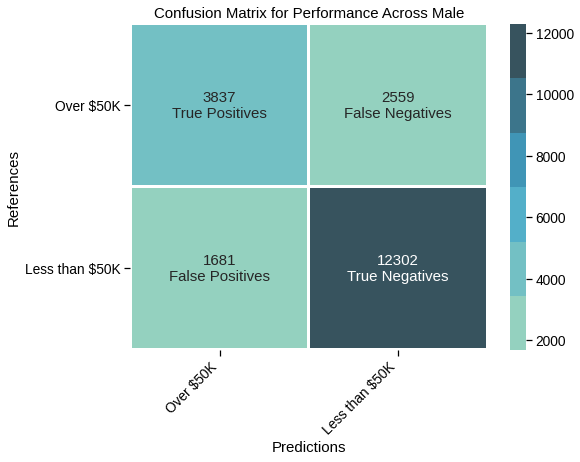

In [23]:
#@title Visualize Binary Confusion Matrix and Compute Evaluation Metrics Per Subgroup
CATEGORY  =  "gender" #@param {type:"string"}
SUBGROUP =  "Male" #@param {type:"string"}

# Labels for annotating axes in plot.
classes = ['Over $50K', 'Less than $50K']

# Given define subgroup, generate predictions and obtain its corresponding 
# ground truth.
subgroup_filter  = test_df.loc[test_df[CATEGORY] == SUBGROUP]
features, labels = pandas_to_numpy(subgroup_filter)
subgroup_results = model.evaluate(x=features, y=labels, verbose=0)
confusion_matrix = np.array([[subgroup_results[1], subgroup_results[4]], 
                             [subgroup_results[2], subgroup_results[3]]])

subgroup_performance_metrics = {
    'ACCURACY': subgroup_results[5],
    'PRECISION': subgroup_results[6], 
    'RECALL': subgroup_results[7],
    'AUC': subgroup_results[8]
}
performance_df = pd.DataFrame(subgroup_performance_metrics, index=[SUBGROUP])
pd.options.display.float_format = '{:,.4f}'.format

plot_confusion_matrix(confusion_matrix, classes, SUBGROUP);
performance_df

Using default parameters, you may find that the model performs better for female than male. Specifically, in our run, we found that both accuracy and AUC for female (0.9137 and 0.9089, respectively) outperformed male (0.7923 and 0.8549, respectively). What is going on here?

Notice the number of true positives (top-left corner) for female is way lower compared to male (479 to 3822). Recall that in Task #1 we noticed a disproportionately high representation of male in the data set (almost 2-to-1). If you further explore the data set using Facets Dive in Task #2 by setting the color to income_bracket and one of the axes to gender, then you will also find a disproportionately small number of female examples in the higher income bracket, our positive label.

What this is all suggesting is that the model is overfitting, particuarly with respect to female and lower income bracket. In other words, this model will not generalize well, particularly with female data, as it does not have enough positive examples for the model to learn from. It is not doing that much better with male, either, as there is a disproportionately small number of high income bracket compared to low income bracket — though not nearly as poorly represented as with female.

Hopefully going through this confusion matrix demonstration you find that the results varies slightly from the overall performance metrics, highlighting the importance of evaluating model performance across subgroup rather than in aggregate.

In your work, make sure that you make a good decision about the tradeoffs between false positives, false negatives, true positives, and true negatives. For example, you may want a very low false positive rate, but a high true positive rate. Or you may want a high precision, but a low recall is okay.